In [1]:
import sys
import os
# Needed to import my modules located in the parent folder
current_directory = os.getcwd().replace('\\', '/')
sys.path.append(f'{current_directory}/Informer2020')

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from torch.utils.data import DataLoader, TensorDataset

from models.model import Informer

import tfg_module.my_get_time_series as mgts
import tfg_module.my_process_data as mpd
import tfg_module.my_future as mf

In [3]:
model_name = 'Informer'
TARGET = 'Ventas' # target can be either Ventas or Compras

In [4]:
ts = mgts.get_ts(TARGET)
ts

,date,Ventas
0,2017-09-30,"5,783"
1,2017-10-31,"20,854"
2,2017-11-30,"14,191"
3,2017-12-31,"7,595"
4,2018-01-31,"12,358"
...,...,...
72,2023-09-30,"16,520"
73,2023-10-31,"17,195"
74,2023-11-30,"13,819"
75,2023-12-31,"21,319"


In [5]:
X, y = mpd.create_features(ts.copy(), target = TARGET, informer = True)

In [6]:
seq_len = 12 # since it is montly data, use the past 12 values for prediction
label_len = 12  # steps introduced in the decoder to start generating forecast. Usually seq_len = label_len
pred_len = 12  # We want one year prediction,  and our data is montly data
enc_in = X.shape[1]  # Xn features (= columns)
dec_in = X.shape[1]  # X features (= columns)
c_out = 1  # We want for each seq_len, one output, one target prediction
freq = 'M'

In [7]:
class InformerWrapper(BaseEstimator, RegressorMixin):
    '''
    Clase Wrapper de informer necesaria para poder aplicar GridSearchCV de la librería sklearn con un
    algoritmo hecho con la librería de Pytorch.
    '''
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, out_len, n_heads=8, dropout=0.05, 
                 freq='M', learning_rate=0.0001, num_epochs=3):
        self.enc_in = enc_in
        self.dec_in = dec_in
        self.c_out = c_out
        self.seq_len = seq_len
        self.label_len = label_len
        self.out_len = out_len
        self.n_heads = n_heads
        self.dropout = dropout
        self.freq = freq
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.model = None

    def fit(self, X, y):
        print('fit')
        self.model = Informer(
            enc_in=self.enc_in,
            dec_in=self.dec_in,
            c_out=self.c_out,
            seq_len=self.seq_len,
            label_len=self.label_len,
            out_len=self.out_len,          
            n_heads=self.n_heads,
            dropout=self.dropout,
            freq=self.freq,
        )
        
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        dataset = self.get_dataset(X, y)
        for epoch in range(self.num_epochs): 
            for batch_x, batch_y in dataset:
                batch_x = torch.unsqueeze(batch_x, dim=0) # Adding batch dimension
                batch_y = torch.unsqueeze(batch_y, dim=0) # Adding batch dimension
                optimizer.zero_grad()
                outputs = self.model(batch_x, batch_x, batch_x, batch_x) # model(x_enc, x_mark_enc, x_dec, x_mark_dec)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        print('training complete')
        self.fitted_ = True
        return self

    def get_dataset(self, X, y):
        dataset = TensorDataset(X, y)
        dataset_batch = DataLoader(dataset, batch_size=12, shuffle=False)
        return dataset_batch
        
    def predict(self, X):
        if not hasattr(self, 'fitted_'):
            raise RuntimeError("You must fit the model before predicting data!")
        
        predictions = []
        with torch.no_grad():
            X = torch.unsqueeze(X, dim=0)  # Adding batch dimension
            outputs = self.model(X, X, X, X)
            predictions.append(outputs.squeeze().numpy())
        return np.concatenate(predictions)

In [8]:
param_grid = {
            'n_heads': [8],
            'dropout': [0.2],
            'learning_rate': [0.1, 0.01, 0.001],
            'num_epochs': [3]
        }

metrics_to_keep = ['neg_mean_absolute_error', 'neg_root_mean_squared_error']

In [9]:
best_model_informer = GridSearchCV(estimator=InformerWrapper(enc_in=enc_in, dec_in=dec_in, c_out=c_out, 
                                                             seq_len=seq_len, label_len=label_len, 
                                                             out_len=pred_len), 
        param_grid = param_grid,
        scoring = metrics_to_keep,
        refit = 'neg_mean_absolute_error', cv = 7)

In [10]:
best_model_informer.fit(X, y)

fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete
fit
training complete


GridSearchCV(cv=7,
             estimator=InformerWrapper(c_out=1, dec_in=7, enc_in=7,
                                       label_len=12, out_len=12, seq_len=12),
             param_grid={'dropout': [0.2], 'learning_rate': [0.1, 0.01, 0.001],
                         'n_heads': [8], 'num_epochs': [3]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'])

In [11]:
results = best_model_informer.cv_results_

In [12]:
opposite_metric = {'neg_mean_absolute_error':'neg_root_mean_squared_error',
                   'neg_root_mean_squared_error':'neg_mean_absolute_error'}

In [13]:
models_by_metric = {}
for metric in metrics_to_keep:
    best_index = results[f'rank_test_{metric}'].argmin()
    best_score = results[f'mean_test_{metric}'][best_index]*-1
    other_metric_score = results[f'mean_test_{opposite_metric[metric]}'][best_index]*-1
    best_params = results['params'][best_index]
    best_model = InformerWrapper(enc_in=enc_in, dec_in=dec_in, c_out=c_out, 
                                 seq_len=seq_len, label_len=label_len, 
                                 out_len=pred_len,**best_params)
    best_model.fit(X, y)
    if metric == 'neg_mean_absolute_error':
        models_by_metric[metric] = (best_model, best_params, best_score, other_metric_score)
    else:
        models_by_metric[metric] = (best_model, best_params, other_metric_score, best_score)
    
best_informer_models_df = pd.DataFrame(models_by_metric)
best_informer_models_df.rename(columns = {'neg_mean_absolute_error':'best_MAE', 'neg_root_mean_squared_error':'best_RMSE'}, inplace = True)
best_informer_models_df.index = ['model', 'parameters', 'mae', 'rmse']

fit
training complete
fit
training complete


In [14]:
best_informer_models_df

,best_MAE,best_RMSE
model,"InformerWrapper(c_out=1, dec_in=7, dropout=0.2...","InformerWrapper(c_out=1, dec_in=7, dropout=0.2..."
parameters,"{'dropout': 0.2, 'learning_rate': 0.1, 'n_head...","{'dropout': 0.2, 'learning_rate': 0.1, 'n_head..."
mae,"10,956","10,956"
rmse,"11,668","11,668"


In [15]:
best_mae_model = best_informer_models_df.loc['model','best_MAE']
best_mae_model

InformerWrapper(c_out=1, dec_in=7, dropout=0.2, enc_in=7, label_len=12,
                learning_rate=0.1, out_len=12, seq_len=12)

In [16]:
best_mae_df = mf.get_pred_df(ts, best_mae_model, informer = True)
best_mae_df

,date,pred
0,2024-01-31,"4,348"
1,2024-02-29,"4,344"
2,2024-03-31,"4,348"
3,2024-04-30,"4,343"
4,2024-05-31,"4,344"
5,2024-06-30,"4,343"
6,2024-07-31,"4,346"
7,2024-08-31,"4,344"
8,2024-09-30,"4,345"
9,2024-10-31,"4,345"


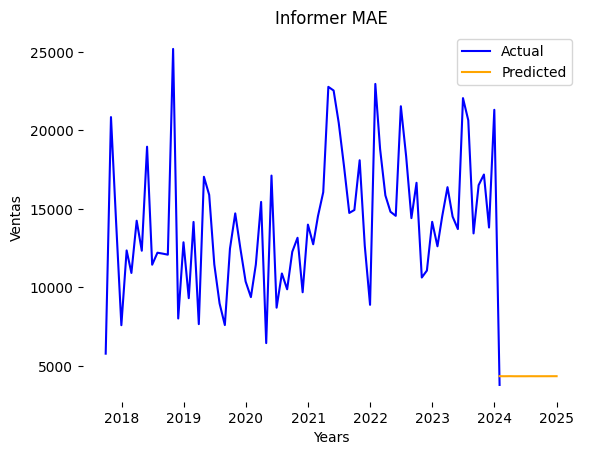

In [17]:
mf.save_pred_plot(model_name, ts, best_mae_df, 'mae')

In [18]:
best_rmse_model = best_informer_models_df.loc['model','best_RMSE']
best_rmse_model

InformerWrapper(c_out=1, dec_in=7, dropout=0.2, enc_in=7, label_len=12,
                learning_rate=0.1, out_len=12, seq_len=12)

In [19]:
best_rmse_df = mf.get_pred_df(ts, best_rmse_model, informer = True)
best_rmse_df

,date,pred
0,2024-01-31,"4,340"
1,2024-02-29,"4,339"
2,2024-03-31,"4,339"
3,2024-04-30,"4,336"
4,2024-05-31,"4,338"
5,2024-06-30,"4,339"
6,2024-07-31,"4,337"
7,2024-08-31,"4,339"
8,2024-09-30,"4,338"
9,2024-10-31,"4,338"


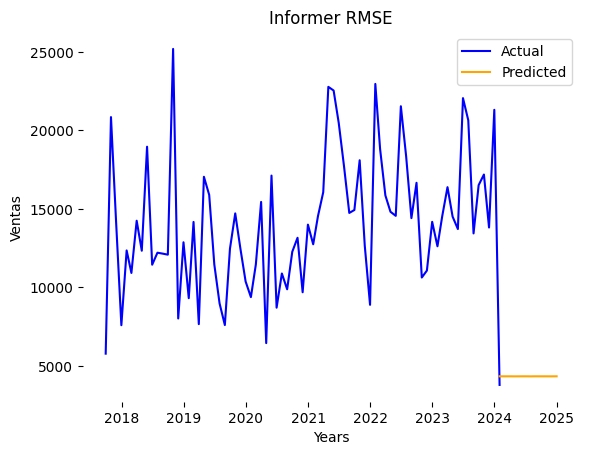

In [20]:
mf.save_pred_plot(model_name, ts, best_rmse_df, 'rmse')